# Demo of Black-box checking of a black-box numeric system

This is a demo of FalCAuN on Jupyter Notebook using the [kotlin-jupyter kernel](https://github.com/Kotlin/kotlin-jupyter). This demo assumes that `jupyter` is executed with the following environmental variables.

- `JAVA_HOME` (the java home for Java 11)

## Dependent packages and logger config

This notebook depends on FalCAuN-core.

In [1]:
@file:DependsOn("net.maswag.falcaun:FalCAuN-core:1.0-SNAPSHOT")

In [2]:
import ch.qos.logback.classic.Level
import ch.qos.logback.classic.Logger
import de.learnlib.driver.simulator.MealySimulatorSUL
import de.learnlib.oracle.membership.SULOracle
import de.learnlib.sul.SUL
import net.automatalib.alphabet.Alphabets
import net.automatalib.automaton.transducer.CompactMealy
import net.automatalib.modelchecker.ltsmin.AbstractLTSmin
import net.automatalib.modelchecker.ltsmin.LTSminVersion
import net.automatalib.util.automaton.builder.AutomatonBuilders
import net.automatalib.visualization.Visualization
import net.maswag.falcaun.*
import org.slf4j.LoggerFactory
import java.util.*

// The following surprises the debug log
var updaterLogger = LoggerFactory.getLogger(AbstractAdaptiveSTLUpdater::class.java) as Logger
updaterLogger.level = Level.INFO
var updateListLogger = LoggerFactory.getLogger(AdaptiveSTLList::class.java) as Logger
updateListLogger.level = Level.INFO
var LTSminVersionLogger = LoggerFactory.getLogger(LTSminVersion::class.java) as Logger
LTSminVersionLogger.level = Level.INFO
var AbstractLTSminLogger = LoggerFactory.getLogger(AbstractLTSmin::class.java) as Logger
AbstractLTSminLogger.level = Level.INFO
var EQSearchProblemLogger = LoggerFactory.getLogger(EQSearchProblem::class.java) as Logger
EQSearchProblemLogger.level = Level.INFO
var SimulinkSteadyStateGeneticAlgorithmLogger = LoggerFactory.getLogger(EQSteadyStateGeneticAlgorithm::class.java) as Logger
SimulinkSteadyStateGeneticAlgorithmLogger.level = Level.INFO

## The target system

Here, we define the target system, a system with a counter. The counter is incremented if a positive value is given. Otherwise, the counter is decremented.

In [3]:
import kotlin.collections.List
import net.automatalib.word.Word

// Define the target system
val target = object : NumericSUL {
    var counter = 0.0
    var numReset = 0
    override fun pre() {
        counter = 0.0
        numReset++
    }
    override fun step(input: List<Double>) : IOSignalPiece<List<Double>> {
        assert (input.size == 1)
        if (input[0] > 0) {
            counter++
        } else {
            counter--
        }
        return IOSignalPiece(input, arrayListOf(counter))
    }
    override fun close() {}
    override fun getCounter(): Int {
        return numReset
    }
    override fun getSimulationTimeSecond(): Double {
        return 0.0
    }
}

The following shows that the behavior of `target` is as expected

In [4]:
target.pre()
target.step(listOf(-1.0)).getOutputSignal()

[-1.0]

In [5]:
target.step(listOf(-2.0)).getOutputSignal()

[-2.0]

In [6]:
target.step(listOf(3.0)).getOutputSignal()

[-1.0]

In [7]:
target.step(listOf(1.0)).getOutputSignal()

[0.0]

In [8]:
target.post()

## The STL properties

Here, we define the STL properties to be tested. 

First, we define the mapper defining the functions $\gamma_I\colon I_A \to I_C$ and $\alpha_O\colon O_C \to O_A$. $\gamma_I$ maps an abstract input with string representation to a concrete alphabet with numeric representation. $\alpha_O$ maps a concrete output with numeric representation to an abstract alphabet with string representation. Moreover, FalCAuN can define "pseudo outputs" by applying some operations to the actual inputs and outputs.

In this example, the abstract input is $I_A = \{a, b\}$ with $\gamma_I(a) = -1.0$ and $\gamma_I(b) = 1.0$.
The abstract output is $O_A = \{aa, ab\}$ such that $\alpha_O(c) = aa \iff |c| \bmod 2 = 0$. Notice that the second dimension of the outputs is for the pseudo output showing $|c| \bmod 2$.

In [9]:
import java.io.BufferedReader
import java.io.StringReader

// Define the input and output mappers
val inputValues = listOf(-1.0, 1.0)
val inputMapper = InputMapperReader.make(listOf(inputValues))
val ignoreValues = listOf(null)
val mod2Values = listOf(0.0, 1.0, null)
val outputMapperReader = OutputMapperReader(listOf(ignoreValues, mod2Values))
outputMapperReader.parse()
// We define the signal mapper such that abs(output(0)) mod 2 is mapped to output(1).
// We need abs because in Java, -1 % 2 == -1.
val mapperString = listOf("abs(output(0)) mod 2").joinToString("\n")
val signalMapper = SimpleSignalMapper.parse(BufferedReader(StringReader(mapperString)))
assert(signalMapper.size() == 1)
val mapper =
    NumericSULMapper(inputMapper, outputMapperReader.largest, outputMapperReader.outputMapper, signalMapper)

The following defines the STL formulas.

In [10]:
// Define STL properties
val stlFactory = STLFactory()
// Note: the given formulas must be safety
val stlList = listOf(
        "[] (output(1) == 0 -> X output(1) == 1)", // This holds
        "[] <> output(1) == 0", // This holds
        "[] <> output(1) == 1", // This holds
        "<>_[0,10] [] output(1) == 0", // This does not hold
        "<>_[0,10] [] output(1) == 1", // This does not hold
        "[] (output(1) == 0)", // This does not hold
        "[] (output(1) == 1)", // This does not hold
        "<>_[0,10] (output(1) == 0 && X output(1) == 0)", // This does not hold
        "<>_[0,10] (output(1) == 1 && X output(1) == 1)", // This does not hold
).map { stlString ->
    stlFactory.parse(stlString, inputMapper, outputMapperReader.outputMapper, outputMapperReader.largest)
}.toList()
val signalLength = 10 // We believe that the traces of length 10 are enough to verify/falsify the properties
val properties = AdaptiveSTLList(stlList, signalLength)

## Run black-box checking

In [11]:
val signalStep = 1.0
// Configure and run the verifier
val verifier = NumericSULVerifier(target, signalStep, properties, mapper)
// Timeout must be set before adding equivalence testing
verifier.setTimeout(5 * 60) // 5 minutes
verifier.addRandomWordEQOracle(
        1, // The minimum length of the random word
        10, // The maximum length of the random word
        1000, // The maximum number of tests
        Random(),
        1
)
val result = verifier.run()
result

false

## Render the learned Mealy machine

The learned Mealy machine can be rendered with Graphviz

In [12]:
import java.io.StringWriter

val dotWriter = StringWriter()
verifier.writeDOTLearnedMealy(dotWriter)

In [13]:
@file:DependsOn("guru.nidi:graphviz-java:0.18.1")

import guru.nidi.graphviz.model.Factory.*
import guru.nidi.graphviz.*
import guru.nidi.graphviz.parse.*
import guru.nidi.graphviz.engine.*
import guru.nidi.graphviz.attribute.*

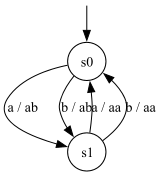

In [14]:
val graph = Parser().read(dotWriter.toString())
Graphviz.fromGraph(graph).render(Format.SVG).toImage()

## Print the result

In [15]:
import net.automatalib.word.Word;

var rawSignals = mutableListOf<IOSignal<List<Double>>>()
for (i in 0 until verifier.cexProperty.size) {
    val dim = mutableListOf<List<Double>>()
    for (j in 0 until verifier.cexConcreteInput[i].size()) {
        dim.add(verifier.cexConcreteInput[i].get(j))
    }
    val inputWord = Word.fromList(dim)
    rawSignals.add(target.execute(inputWord))
}

In [16]:
if (result) {
    println("All the properties are likely satisfied")
} else {
    for (i in 0 until verifier.cexProperty.size) {
        println("${verifier.cexProperty[i]} is falsified by the following counterexample:")
        println("cex abstract input: ${verifier.cexAbstractInput[i]}")
        println("cex abstract output: ${verifier.cexOutput[i]}")
        println("cex concrete input: ${rawSignals[i].inputSignal}")
        println("cex concrete output: ${rawSignals[i].outputSignal}")
    }
}

 <>_[0, 10] ( [] ( output(1) == 0.000000 ) ) is falsified by the following counterexample:
cex abstract input: b b b b b b b b b b b
cex abstract output: ab aa ab aa ab aa ab aa ab aa ab
cex concrete input: [1.0] [1.0] [1.0] [1.0] [1.0] [1.0] [1.0] [1.0] [1.0] [1.0] [1.0]
cex concrete output: [1.0] [2.0] [3.0] [4.0] [5.0] [6.0] [7.0] [8.0] [9.0] [10.0] [11.0]
 <>_[0, 10] ( [] ( output(1) == 1.000000 ) ) is falsified by the following counterexample:
cex abstract input: b b b b b b b b b b b b
cex abstract output: ab aa ab aa ab aa ab aa ab aa ab aa
cex concrete input: [1.0] [1.0] [1.0] [1.0] [1.0] [1.0] [1.0] [1.0] [1.0] [1.0] [1.0] [1.0]
cex concrete output: [1.0] [2.0] [3.0] [4.0] [5.0] [6.0] [7.0] [8.0] [9.0] [10.0] [11.0] [12.0]
[] ( output(1) == 0.000000 ) is falsified by the following counterexample:
cex abstract input: b
cex abstract output: ab
cex concrete input: [1.0]
cex concrete output: [1.0]
[] ( output(1) == 1.000000 ) is falsified by the following counterexample:
cex abstr